In [1]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


/software/cellgen/team361/aa34/envs/disect/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from celldisect import CellDISECT
import rapids_singlecell as rsc
# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [3]:
adata = sc.read_h5ad('../kang_normalized_hvg.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()

In [4]:
adata.layers['counts'].max()

3828.0

In [5]:
adata.X.max()

9.0423

In [6]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [7]:
cats = ['cell_type', 'condition']
cell_type_included = False # Set to True if you have provided a cell type annotation in the cats list
if not cell_type_included:
    adata.obs["_cluster"] = (
        "0"  # Dummy obs for inference (not-training) time, to avoid computing neighbors and clusters again in setup_anndata | AVOID ADDING BEFORE TRAINING
    )
pre_path = '../models/kang_ablation_celldisect_cfW_all1_focused/'
model_paths = []
for model_path in os.listdir(pre_path):
    if 'CD14 Mono' in model_path:
        model_paths.append(model_path)

In [8]:
model_paths

['celldisect_allones_cfW_2.5_split_split_CD14 Mono',
 'celldisect_allones_cfW_7.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_10.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_8.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_4.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_4.5_split_split_CD14 Mono',
 'celldisect_allones_cfW_2.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.3_split_split_CD14 Mono',
 'celldisect_allones_cfW_5.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_3.5_split_split_CD14 Mono',
 'celldisect_allones_cfW_9.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_1.5_split_split_CD14 Mono',
 'celldisect_allones_cfW_3.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.5_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.1_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.05_split_split_CD14 Mono',
 'celldisect_allones_cfW_0.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_6.0_split_split_CD14 Mono',
 'celldisect_allones_cfW_1.0_split_split_CD1

In [9]:
names = [name.split('_')[3] for name in model_paths]
names

['2.5',
 '7.0',
 '10.0',
 '8.0',
 '4.0',
 '4.5',
 '2.0',
 '0.3',
 '5.0',
 '3.5',
 '9.0',
 '1.5',
 '3.0',
 '0.5',
 '0.1',
 '0.05',
 '0.0',
 '6.0',
 '1.0',
 '0.8']

In [10]:
models = {}
for i, model_path in enumerate(model_paths):
    models[names[i]] = CellDISECT.load(f"{pre_path}/{model_path}", adata=adata)

INFO     File ../models/kang_ablation_celldisect_cfW_all1_focused//celldisect_allones_cfW_2.5_split_split_CD14     
         Mono/model.pt already downloaded                                                                          


CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     File ../models/kang_ablation_celldisect_cfW_all1_focused//celldisect_allones_cfW_7.0_split_split_CD14     
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_focused//celldisect_allones_cfW_10.0_split_split_CD14    
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_focused//celldisect_allones_cfW_8.0_split_split_CD14     
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_focused//celldisect_allones_cfW_4.0_split_split_CD14     
         Mono/model.pt already downloaded                                                                          
INFO     File ../models/kang_ablation_celldisect_cfW_all1_focused//celld

In [11]:
models = dict(sorted(models.items(), key=lambda t: float(t[0])))

In [12]:
n_samples_from_source_max = 500

In [13]:
adata_ = adata[adata.obs['cell_type'] == 'CD14 Mono'].copy()
n_samples_from_source = min(n_samples_from_source_max, len(adata_[(adata_.obs['condition'] == 'ctrl')]))

cov_names = ['condition']
cov_values = ['ctrl']
cov_values_cf = ['stimulated']

In [14]:
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
adata.obs['cov_condition'] = adata.obs['cell_type'].astype(str) + '_' + adata.obs.condition.astype(str)

groupby='cov_condition'
control_group='ctrl'
key_added="rank_genes_groups_pval0.05"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
covariate = 'cell_type'
cov_categories = adata.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # name of the control group in the groupby obs column
    control_group_cov = "_".join([cov_cat, control_group])
    adata_cov = adata[adata.obs[covariate] == cov_cat]

    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )

    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns

    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        # de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=None, log2fc_min=None, log2fc_max=None)['names']
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['logfoldchanges']

        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)

        gene_dict[group] = de_genes[group].tolist()

adata.uns[key_added] = gene_dict
adata.X = adata.layers['counts'].copy()

CD14 Mono
CD4 T
T
CD8 T
B
DC
CD16 Mono
NK


In [29]:
RANDOM_SEED = 42
preds = {}
for name, model in models.items():
    x_ctrl, x_true, x_pred = model.predict_counterfactuals(
                                            adata_.copy(),
                                            cov_names=cov_names,
                                            cov_values=cov_values,
                                            cov_values_cf=cov_values_cf,
                                            cats=cats,
                                            n_samples_from_source=n_samples_from_source,
                                            seed=RANDOM_SEED,
                                            )

    x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)
    preds[name] = x_pred

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer set

In [30]:
deg_list = adata.uns[key_added]['CD14 Mono_stimulated']

In [31]:
from scipy.stats import wasserstein_distance

emd_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    emd_results[str(n_top_deg)] = {}
    for name, x_pred in preds.items():
        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]
        # for method_name, method in zip(['CellDISECT', 'Control'], [x_pred_deg, x_ctrl_deg]):
        wd = []
        for i in range(x_true_deg.shape[1]):
            wd.append(
                wasserstein_distance(torch.tensor(x_true_deg[:, i]), torch.tensor(x_pred_deg[:, i]))
            )
        emd_results[str(n_top_deg)][name] = np.mean(wd)

emd_results = pd.DataFrame.from_dict(emd_results).T
emd_results

,0.0,0.05,0.1,0.3,0.5,0.8,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0
20,1.503178,1.503497,1.502730,1.503000,1.503253,1.502277,1.502981,1.502986,1.507971,1.507891,1.507739,1.507511,1.505974,1.506242,1.505217,1.502813,1.501496,1.501227,1.500282,1.500188
all,0.240953,0.241031,0.240999,0.241021,0.241054,0.240983,0.240932,0.240963,0.232352,0.232294,0.232553,0.232281,0.232564,0.232869,0.232729,0.232453,0.232508,0.232006,0.232147,0.231668


In [32]:
r2_results = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    r2_results[str(n_top_deg)] = {}
    for name, x_pred in preds.items():
        
        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]

        r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))

        r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))

        r2_results[str(n_top_deg)][name] = r2_mean_deg[0]

        r2_results[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

r2_results = pd.DataFrame.from_dict(r2_results).T
r2_results

,0.0,0.0_var,0.05,0.05_var,0.1,0.1_var,0.3,0.3_var,0.5,0.5_var,...,6.0,6.0_var,7.0,7.0_var,8.0,8.0_var,9.0,9.0_var,10.0,10.0_var
20,0.658267,0.086365,0.655810,0.090575,0.652141,0.070279,0.664395,0.103667,0.659200,0.124256,...,0.705605,-0.036533,0.709256,-0.018979,0.716639,-0.013032,0.713904,-0.010575,0.719575,-0.016064
all,0.142953,0.044431,0.140353,0.042820,0.142567,0.043637,0.142298,0.044553,0.140711,0.046174,...,0.140586,0.038111,0.142012,0.039796,0.143387,0.040173,0.142944,0.041261,0.146502,0.042267


In [33]:
r2_results_subtract = {}
for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'
    r2_results_subtract[str(n_top_deg)] = {}
    for name, x_pred in preds.items():

        x_true_deg = x_true[:, degs]
        x_pred_deg = x_pred[:, degs]
        x_ctrl_deg = x_ctrl[:, degs]


        r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))

        r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

        r2_results_subtract[str(n_top_deg)][name] = r2_mean_deg[0]

        r2_results_subtract[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T
r2_results_subtract

,0.0,0.0_var,0.05,0.05_var,0.1,0.1_var,0.3,0.3_var,0.5,0.5_var,...,6.0,6.0_var,7.0,7.0_var,8.0,8.0_var,9.0,9.0_var,10.0,10.0_var
20,-0.069398,0.208577,-0.079906,0.208638,-0.068822,0.207699,-0.061171,0.209464,-0.076988,0.210907,...,0.443419,0.195538,0.456486,0.197929,0.460444,0.199314,0.471758,0.199125,0.478522,0.198339
all,0.027965,0.084533,0.027891,0.084485,0.028087,0.084470,0.028138,0.084510,0.028125,0.084623,...,0.025424,0.082707,0.026124,0.082863,0.025981,0.082915,0.026369,0.083116,0.026523,0.082990


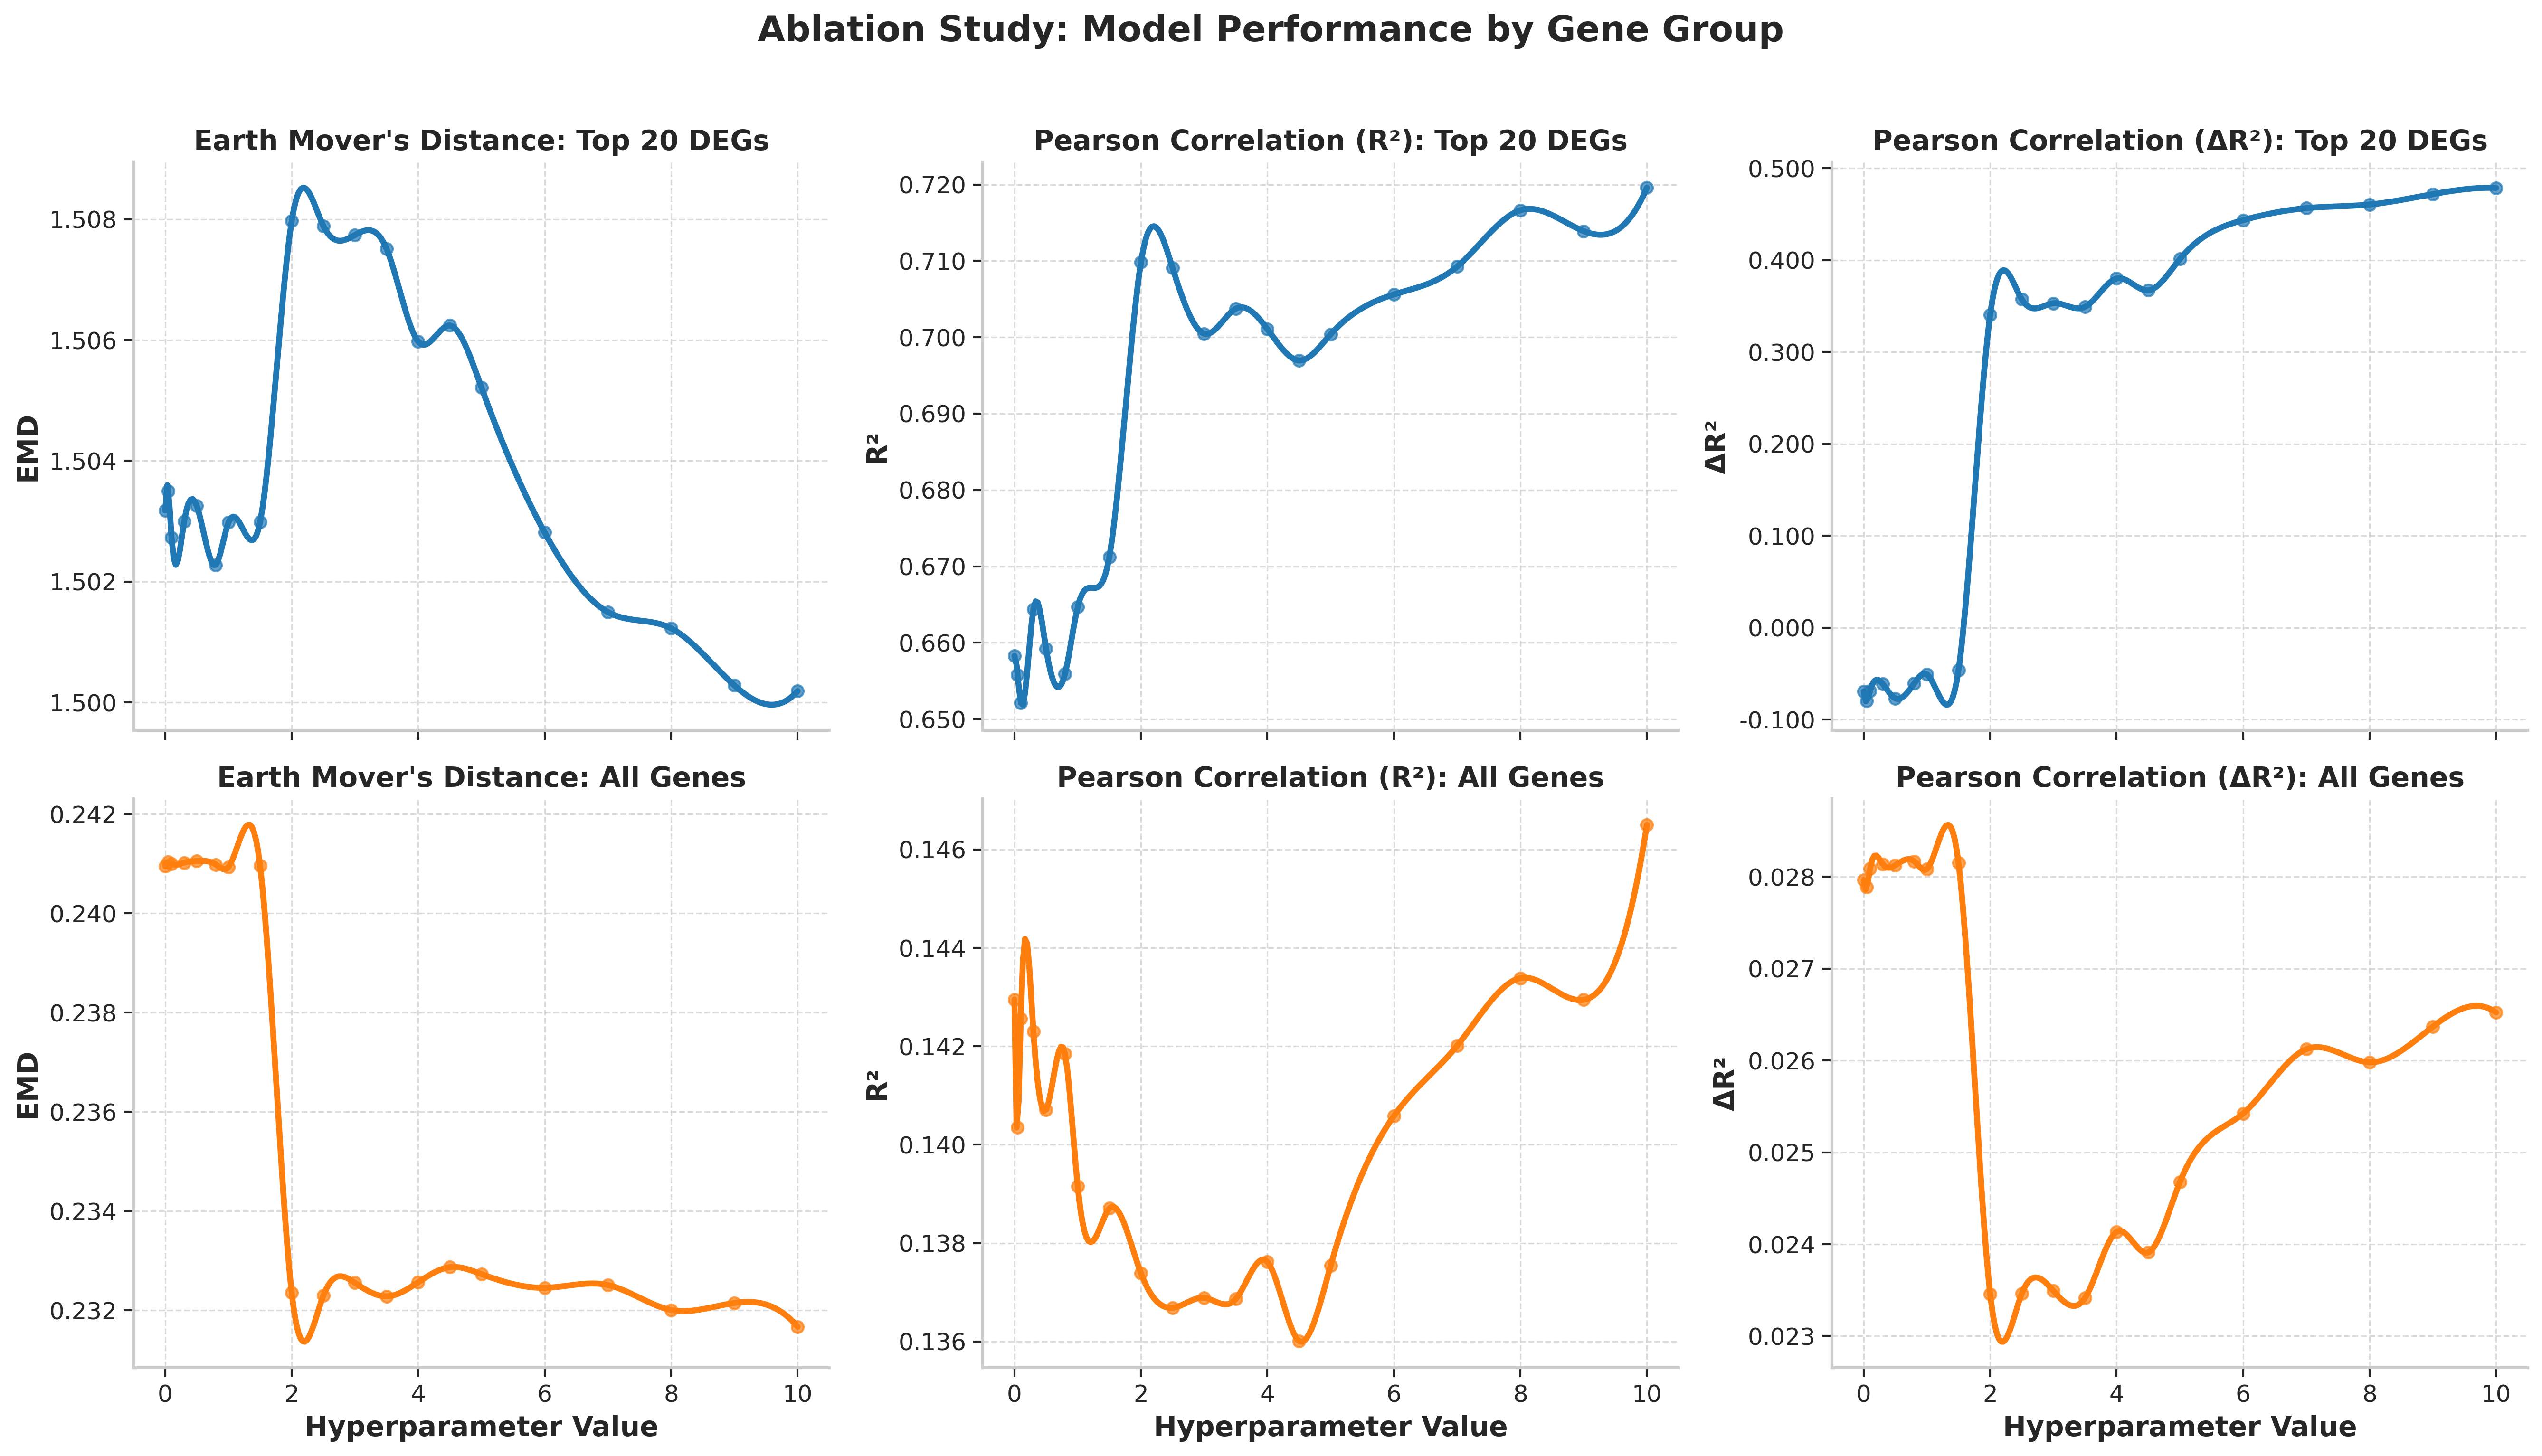

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

# Function to create smooth curve
def smooth_curve(x, y, smoothness=300):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=3)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a plot with smoothed lines for better visualization with different y-scales
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes[0, i].set_ylabel(metric_name, fontweight='bold')
    axes[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[0, i].grid(True, linestyle='--', alpha=0.7)
    axes[0, i].spines['top'].set_visible(False)
    axes[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[1, i].set_ylabel(metric_name, fontweight='bold')
    axes[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes[1, i].grid(True, linestyle='--', alpha=0.7)
    axes[1, i].spines['top'].set_visible(False)
    axes[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figure
plt.show()

20 | EMD Score
20 | R² Score
20 | Differential R² Score
all | EMD Score
all | R² Score
all | Differential R² Score


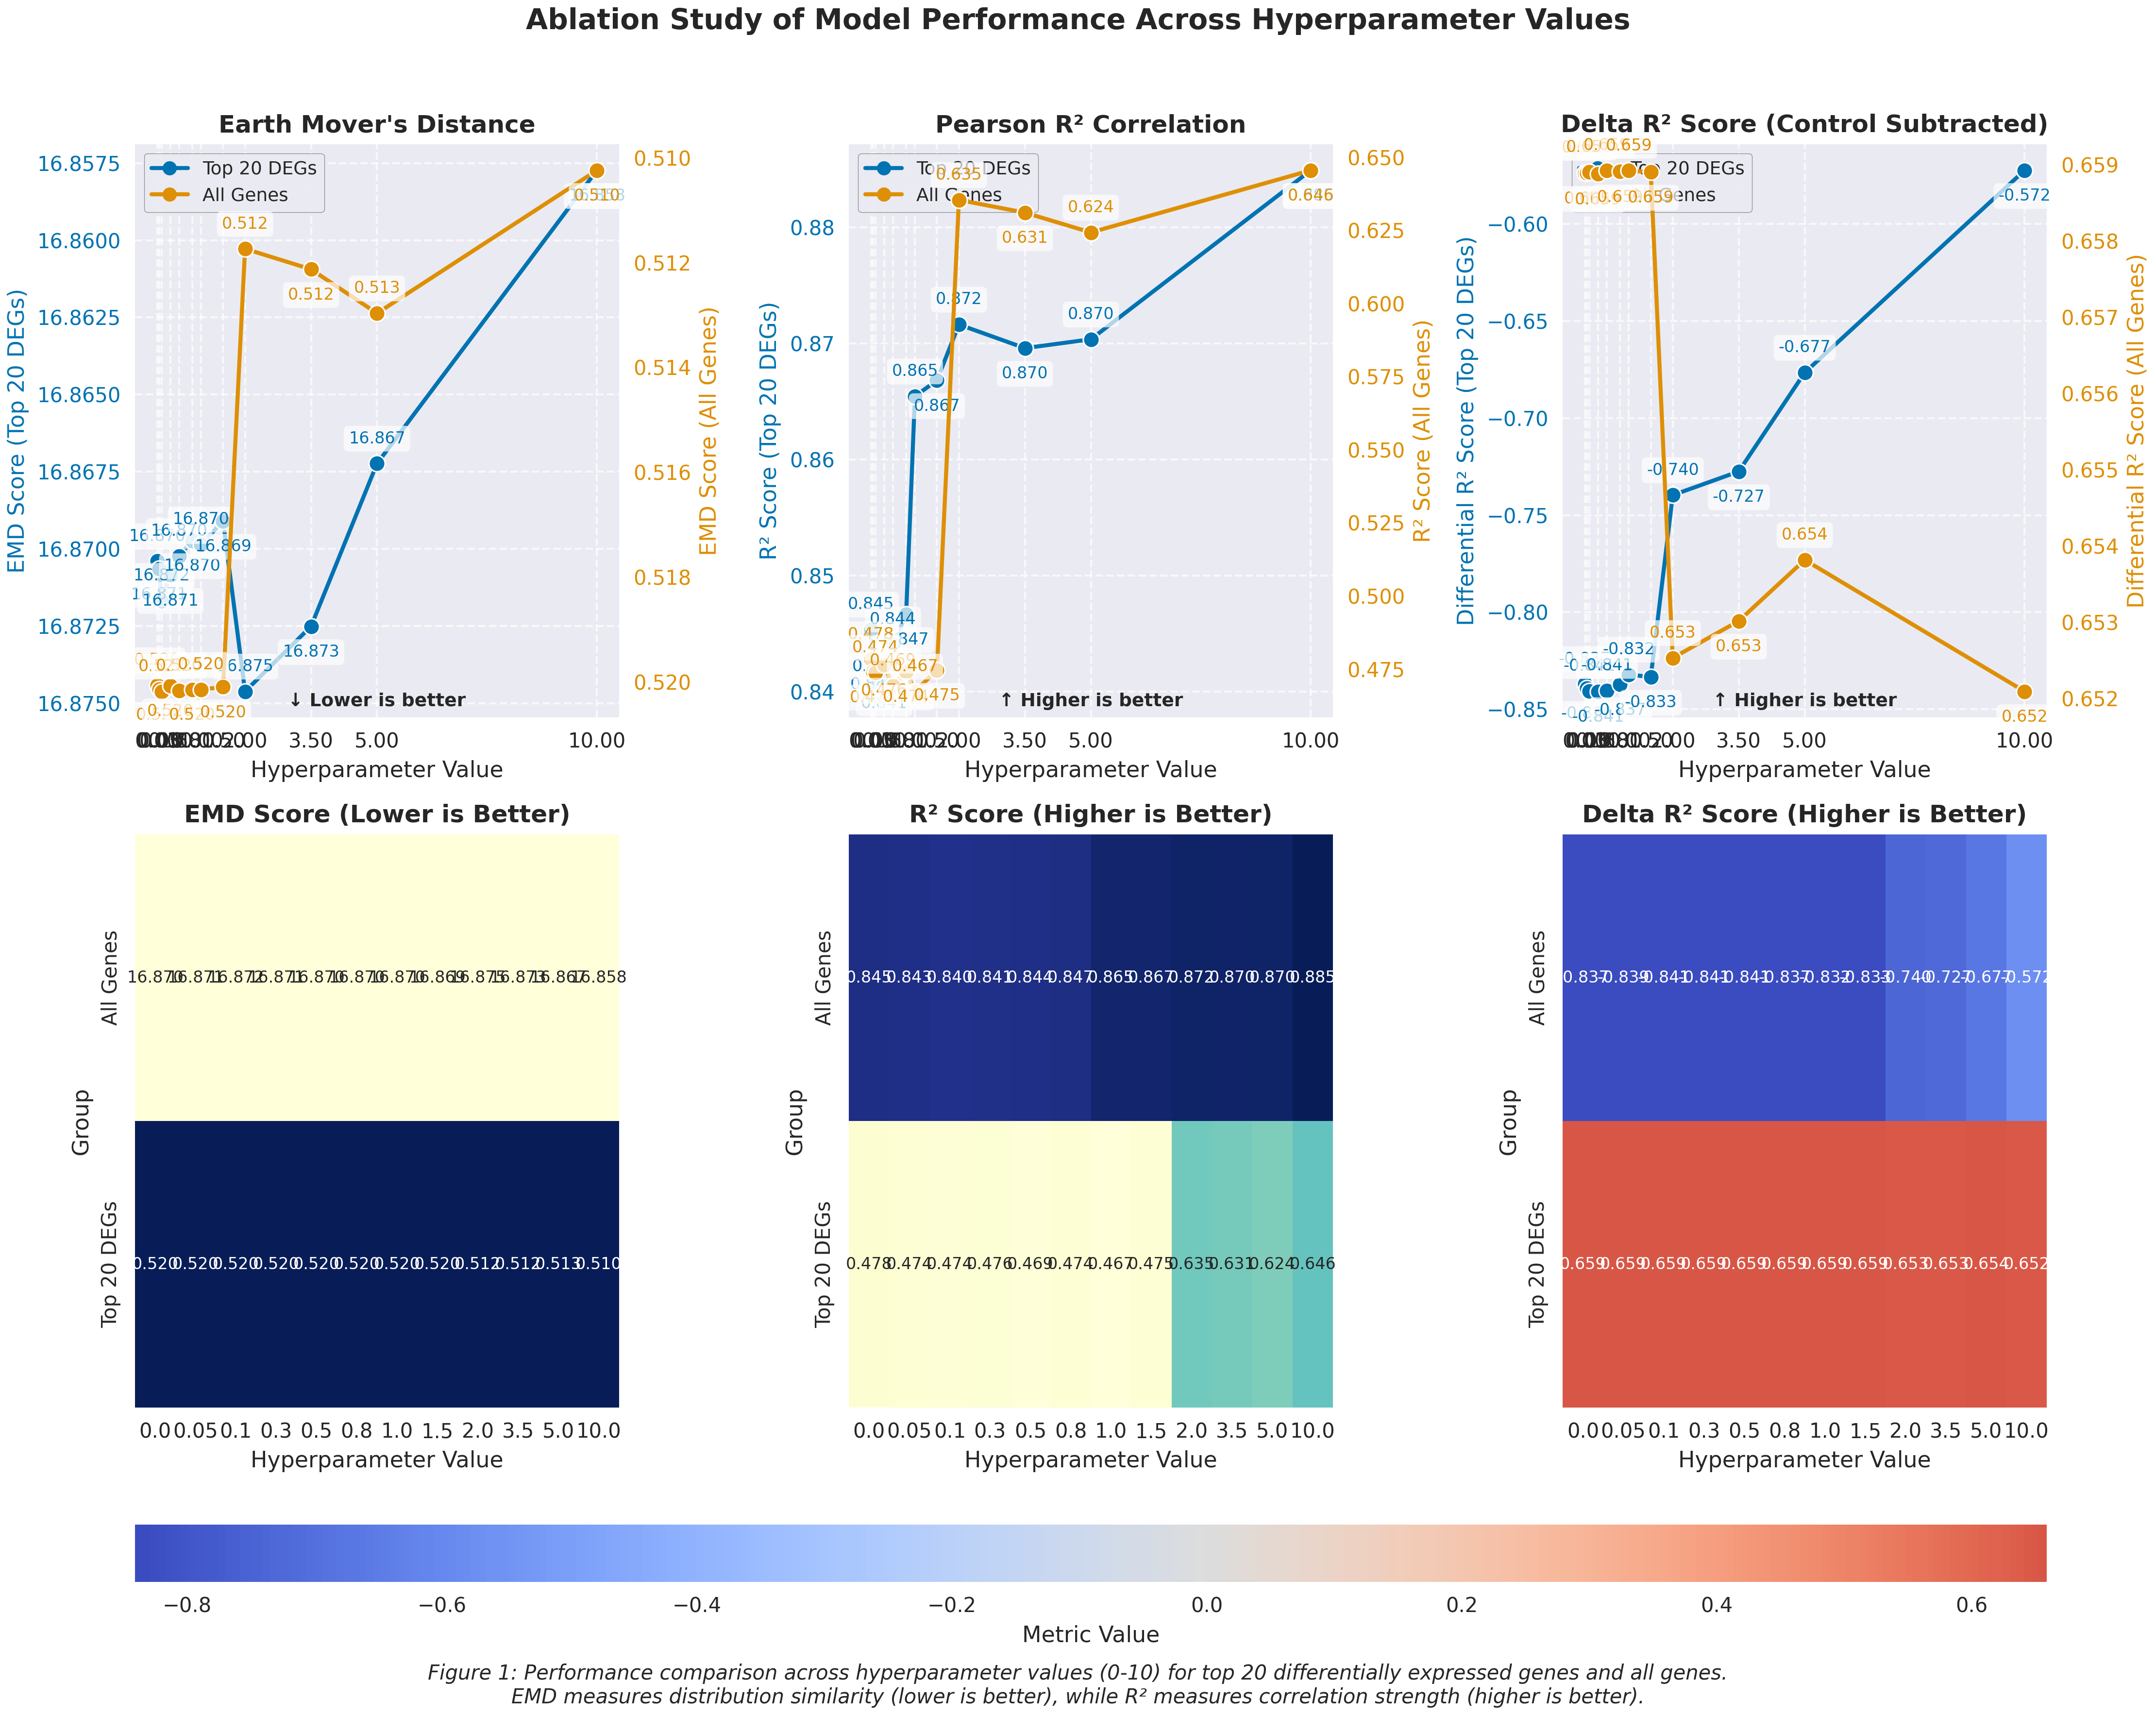

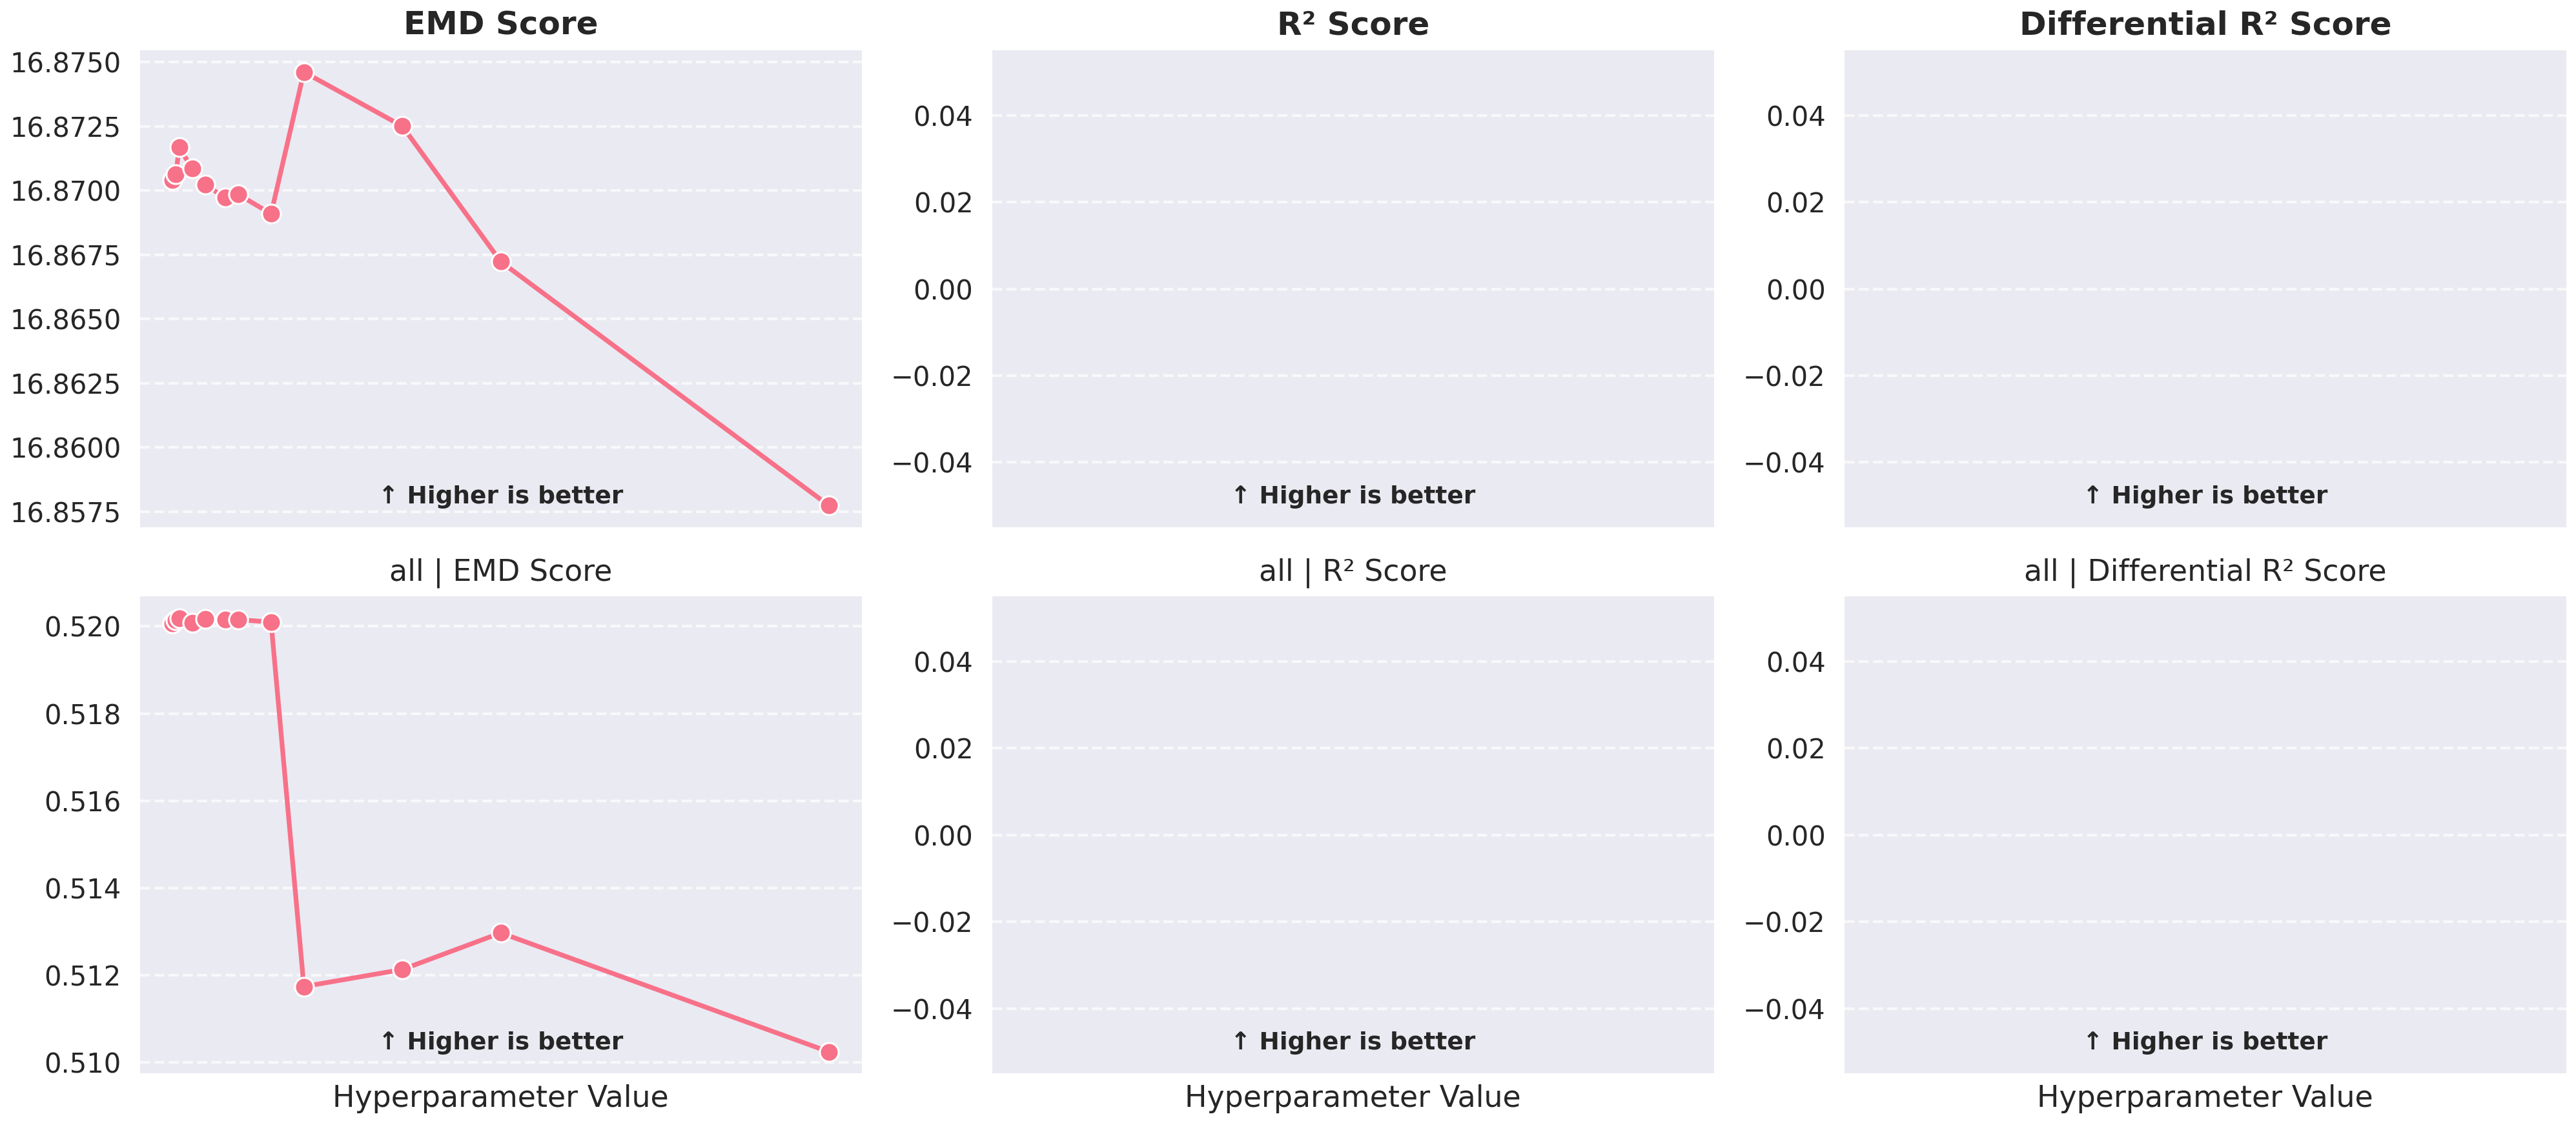

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

# For consistent, publication-quality styling
plt.rcParams.update({
    # 'font.family': 'sans-serif',
    # 'font.sans-serif': ['Arial'],
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.figsize': (15, 10),
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
})

# Assuming your dataframes look something like this (mocking the data structure)
# Let's reshape the data for better visualization

# Helper function to reshape data
def reshape_for_plotting(df, metric_name):
    """Reshape dataframe for plotting with seaborn."""
    # Create a list to hold rows
    rows = []
    
    for idx, row in df.iterrows():
        group = idx  # '20' or 'all'
        for col in row.index:
            # Skip variance columns
            if '_var' in col:
                continue
                
            # Parse hyperparameter value from column name
            hyperparam = float(col)

            rows.append({
                'Group': group,
                'Hyperparameter': hyperparam,
                metric_name: row[col]
            })
    
    return pd.DataFrame(rows)

# Assuming these are your dataframes with results
# If this is not the structure, adjust accordingly
emd_data = reshape_for_plotting(emd_results, 'EMD Score')
r2_data = reshape_for_plotting(r2_results, 'R² Score')
r2_subtract_data = reshape_for_plotting(r2_results_subtract, 'Differential R² Score')

# Create a composite figure with all three metrics
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 0.1])

# Color palette that's colorblind-friendly
colors = sns.color_palette("colorblind")

# Function to create separate subplots for each group to handle different scales
def create_dual_axis_plots(ax1, ax2, data, metric_name, title, invert_y=False):
    # Filter data for each group
    top20_data = data[data['Group'] == '20']
    all_data = data[data['Group'] == 'all']
    
    # Plot Top 20 DEGs on left y-axis
    line1 = sns.lineplot(
        data=top20_data, 
        x='Hyperparameter', 
        y=metric_name, 
        marker='o',
        markersize=8,
        linewidth=2,
        color=colors[0],
        ax=ax1
    )
    
    # Plot All Genes on right y-axis
    ax2.spines['right'].set_visible(True)
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    
    line2 = sns.lineplot(
        data=all_data, 
        x='Hyperparameter', 
        y=metric_name, 
        marker='o',
        markersize=8,
        linewidth=2,
        color=colors[1],
        ax=ax2
    )
    
    # Set titles and labels
    ax1.set_title(title, fontweight='bold')
    ax1.set_xlabel('Hyperparameter Value')
    ax1.set_ylabel(f'{metric_name} (Top 20 DEGs)', color=colors[0])
    ax2.set_ylabel(f'{metric_name} (All Genes)', color=colors[1])
    
    # Set tick colors
    ax1.tick_params(axis='y', colors=colors[0])
    ax2.tick_params(axis='y', colors=colors[1])
    
    # Set integer ticks on x-axis with custom values
    hyper_values = np.sort(data['Hyperparameter'].unique())
    ax1.set_xticks(hyper_values)
    
    # Optional: invert y-axis for metrics where lower is better
    if invert_y:
        ax1.invert_yaxis()
        ax2.invert_yaxis()
        direction_text = '↓ Lower is better'
    else:
        direction_text = '↑ Higher is better'
    
    # Add annotation for "better" direction
    ax1.annotate(direction_text, xy=(0.5, 0.02), xycoords='axes fraction', 
                fontsize=9, ha='center', fontweight='bold')
    
    # Add gridlines but only from the left axis
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax2.grid(False)
    
    # Add text annotations for values - carefully positioned to avoid overlap
    for i, row in top20_data.iterrows():
        if i % 2 == 0:  # Stagger annotations to avoid overlap
            y_offset = 10
        else:
            y_offset = -15
        
        ax1.annotate(
            f"{row[metric_name]:.3f}",
            (row['Hyperparameter'], row[metric_name]),
            textcoords="offset points",
            xytext=(0, y_offset),
            ha='center',
            fontsize=8,
            color=colors[0],
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7)
        )
    
    for i, row in all_data.iterrows():
        if i % 2 == 0:  # Stagger annotations to avoid overlap
            y_offset = 10
        else:
            y_offset = -15
            
        ax2.annotate(
            f"{row[metric_name]:.3f}",
            (row['Hyperparameter'], row[metric_name]),
            textcoords="offset points",
            xytext=(0, y_offset),
            ha='center',
            fontsize=8,
            color=colors[1],
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7)
        )
    
    # Create a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=colors[0], lw=2, marker='o', label='Top 20 DEGs'),
        Line2D([0], [0], color=colors[1], lw=2, marker='o', label='All Genes')
    ]
    ax1.legend(handles=legend_elements, loc='best', frameon=True, framealpha=0.9, edgecolor='gray')

# Create the individual plots with dual y-axes
ax_emd1 = fig.add_subplot(gs[0, 0])
ax_emd2 = ax_emd1.twinx()
create_dual_axis_plots(ax_emd1, ax_emd2, emd_data, 'EMD Score', 'Earth Mover\'s Distance', invert_y=True)

ax_r2_1 = fig.add_subplot(gs[0, 1])
ax_r2_2 = ax_r2_1.twinx()
create_dual_axis_plots(ax_r2_1, ax_r2_2, r2_data, 'R² Score', 'Pearson R² Correlation')

ax_r2diff_1 = fig.add_subplot(gs[0, 2])
ax_r2diff_2 = ax_r2diff_1.twinx()
create_dual_axis_plots(ax_r2diff_1, ax_r2diff_2, r2_subtract_data, 'Differential R² Score', 'Delta R² Score (Control Subtracted)')

# Function to create improved heatmaps with better colormaps and formatting
def create_heatmap(ax, data, title, cmap, center=None, fmt='.3f'):
    # Get unique hyperparameter values and sort them
    hyper_values = np.sort(data['Hyperparameter'].unique())
    
    # Create pivot table
    pivot_data = data.pivot(index='Group', columns='Hyperparameter', values=data.columns[-1])
    
    # Ensure hyperparameter columns are in the correct order
    pivot_data = pivot_data[hyper_values]
    
    # Create heatmap
    sns.heatmap(
        pivot_data, 
        annot=True, 
        cmap=cmap, 
        fmt=fmt,
        center=center,
        cbar=False,
        ax=ax,
        annot_kws={"size": 8}
    )
    
    # Rename row indices for better readability
    ax.set_yticklabels(['All Genes', 'Top 20 DEGs'])
    
    # Set title and labels
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Hyperparameter Value')

# Create heatmaps with improved colormaps
ax_hm_emd = fig.add_subplot(gs[1, 0])
create_heatmap(
    ax_hm_emd, 
    emd_data, 
    'EMD Score (Lower is Better)', 
    cmap='YlGnBu_r'
)

ax_hm_r2 = fig.add_subplot(gs[1, 1])
create_heatmap(
    ax_hm_r2, 
    r2_data, 
    'R² Score (Higher is Better)', 
    cmap='YlGnBu'
)

ax_hm_r2diff = fig.add_subplot(gs[1, 2])
create_heatmap(
    ax_hm_r2diff, 
    r2_subtract_data, 
    'Delta R² Score (Higher is Better)', 
    cmap='coolwarm',
    center=0
)

# Add a colorbar
cax = fig.add_subplot(gs[2, :])
plt.colorbar(ax_hm_r2diff.collections[0], cax=cax, orientation='horizontal', label='Metric Value')

# Main figure title
fig.suptitle('Ablation Study of Model Performance Across Hyperparameter Values', 
             fontsize=14, fontweight='bold', y=0.98)

# Add explanatory text
fig.text(0.5, 0.01, 
         'Figure 1: Performance comparison across hyperparameter values (0-10) for top 20 differentially expressed genes and all genes.\n'
         'EMD measures distribution similarity (lower is better), while R² measures correlation strength (higher is better).',
         ha='center', fontsize=10, style='italic')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save the figure
plt.savefig('ablation_study_results_improved.png', dpi=300, bbox_inches='tight')
plt.savefig('ablation_study_results_improved.pdf', dpi=300, bbox_inches='tight')

# Create a more detailed facet plot that shows individual metrics with proper scaling
def create_facet_grid(data1, data2, data3, filename):
    # Combine all data into a single dataframe for facet grid
    data1 = data1.copy()
    data1['Metric'] = 'EMD Score'
    data2 = data2.copy()
    data2['Metric'] = 'R² Score'
    data3 = data3.copy()
    data3['Metric'] = 'Differential R² Score'
    
    combined_data = pd.concat([data1, data2, data3])
    
    # Create facet grid
    g = sns.FacetGrid(
        combined_data, 
        col='Metric', 
        row='Group', 
        height=3, 
        aspect=1.5,
        sharex=True,
        sharey=False
    )
    
    # Map lineplot to the grid
    g.map_dataframe(sns.lineplot, x='Hyperparameter', y=combined_data.columns[2], marker='o')
    
    # Add titles and improve layout
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set_axis_labels("Hyperparameter Value", "")
    
    # For each axis, annotate the values
    for ax in g.axes.flat:
        title = ax.get_title()
        print(title)
        metric = title.split('|')[0]
        group = title.split('|')[1].strip()
        
        # Filter data for this subplot
        subplot_data = combined_data[
            (combined_data['Metric'] == metric) & 
            (combined_data['Group'] == group)
        ]
        
        # Add value annotations
        for i, row in subplot_data.iterrows():
            if i % 2 == 0:  # Stagger to avoid overlap
                y_offset = 7
            else:
                y_offset = -15
                
            ax.annotate(
                f"{row[subplot_data.columns[2]]:.3f}",
                (row['Hyperparameter'], row[subplot_data.columns[2]]),
                textcoords="offset points",
                xytext=(0, y_offset),
                ha='center',
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7)
            )
        
        # Add directional indicator
        if metric == 'EMD Score':
            ax.text(0.5, 0.05, '↓ Lower is better', transform=ax.transAxes, 
                   ha='center', fontsize=9, fontweight='bold')
            # For EMD, set ylim with a buffer of 10% of the range
            data_range = subplot_data['EMD Score'].max() - subplot_data['EMD Score'].min()
            buffer = data_range * 0.1 if data_range > 0 else 0.1
            ax.set_ylim([subplot_data['EMD Score'].min() - buffer, 
                         subplot_data['EMD Score'].max() + buffer])
        else:
            ax.text(0.5, 0.05, '↑ Higher is better', transform=ax.transAxes, 
                   ha='center', fontsize=9, fontweight='bold')
        
        # Set integer x-ticks
        hyper_values = np.sort(subplot_data['Hyperparameter'].unique())
        ax.set_xticks(hyper_values)
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Fix column titles to be at the top of the figure
    for ax, col in zip(g.axes[0], g.col_names):
        ax.set_title(col, fontweight='bold')
    
    # Improve spacing and layout
    plt.tight_layout()
    plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{filename}.pdf', dpi=300, bbox_inches='tight')
    
# Create the facet grid version
create_facet_grid(emd_data, r2_data, r2_subtract_data, 'ablation_study_facet')

plt.show()